# @Xiufan: Please update the aws-braket-sdk and the qiskit-braket-provider to their latest package version

In [2]:
### To update the packages, just run this command in your terminal please

!pip install amazon-braket-sdk==1.72.2 
!pip install qiskit-braket-provider==0.1.1

  Obtaining dependency information for amazon-braket-sdk==1.72.2 from https://files.pythonhosted.org/packages/ed/16/d9dbe55cc40605840ac5daf54e9ea95cfc3b78b571ccdbe60796785ac2d6/amazon_braket_sdk-1.72.2-py3-none-any.whl.metadata
  Obtaining dependency information for amazon-braket-schemas>=1.20.2 from https://files.pythonhosted.org/packages/85/72/794586305f1635160afface6d11239b8d012e59437c4c9efe9b8661540c8/amazon_braket_schemas-1.20.2-py3-none-any.whl.metadata
  Obtaining dependency information for amazon-braket-default-simulator>=1.19.1 from https://files.pythonhosted.org/packages/97/7c/eafebaa86e8e92b5507824562d53aab022c906725431e99d6de22b96b748/amazon_braket_default_simulator-1.20.4-py3-none-any.whl.metadata
  Obtaining dependency information for oqpy~=0.3.5 from https://files.pythonhosted.org/packages/fb/6f/89dca9f43d31d0e5ff141d9c70693b14677463c7ced1cb367327e6903a5f/oqpy-0.3.5-py3-none-any.whl.metadata
  Obtaining dependency information for backoff from https://files.pythonhosted.o

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.5.0 requires botocore<1.29.77,>=1.29.76, but you have botocore 1.34.55 which is incompatible.


  Obtaining dependency information for qiskit-braket-provider==0.1.1 from https://files.pythonhosted.org/packages/a1/63/d1cfc3fbd48a87bdce2eef8e963d0b4a989e276740680ee99375a393787b/qiskit_braket_provider-0.1.1-py3-none-any.whl.metadata
  Obtaining dependency information for qiskit-ionq>=0.4.7 from https://files.pythonhosted.org/packages/7c/36/c9231dca13695e24a34a6f13e1642595be119db12424ff70142c0bb2442a/qiskit_ionq-0.5.0-py3-none-any.whl.metadata
  Obtaining dependency information for retry>=0.9.0 from https://files.pythonhosted.org/packages/4b/0d/53aea75710af4528a25ed6837d71d117602b01946b307a3912cb3cfcbcba/retry-0.9.2-py2.py3-none-any.whl.metadata
  Obtaining dependency information for py<2.0.0,>=1.4.26 from https://files.pythonhosted.org/packages/f6/f0/10642828a8dfb741e5f3fbaac830550a518a775c7fff6f04a007259b0548/py-1.11.0-py2.py3-none-any.whl.metadata
Using cached retry-0.9.2-py2.py3-none-any.whl (8.0 kB)
Using cached py-1.11.0-py2.py3-none-any.whl (98 kB)


#### Running a bell circuit on different backends

In [3]:
import numpy as np
import time

from braket.circuits import Circuit
from qiskit_braket_provider import AWSBraketProvider
from braket.aws import AwsSession

from qiskit import QuantumCircuit
from qiskit.primitives import BackendEstimator, Estimator
from qiskit.quantum_info.operators import SparsePauliOp
from qiskit.primitives import BackendEstimator

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

# TODO: Please adjust the S3 bucket to one of yours

In [4]:
aws_session = AwsSession(default_bucket="xiufan-bucket-prgroup") # TODO: Please replace with your S3 bucket

In [5]:
batchsize = 50
n_shots = 10_000

#### Run with native Braket SV Backend

In [6]:
backend = AWSBraketProvider().get_backend('SV1')

device = backend._device
device

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)

In [7]:
braket_bell_circ = Circuit().h(0).cnot(0, 1)
print(braket_bell_circ)

T  : |0|1|
          
q0 : -H-C-
        | 
q1 : ---X-

T  : |0|1|


In [8]:
start_time = time.time()
job_braket_native = device.run_batch(
    [braket_bell_circ] * batchsize,
    shots=n_shots,
)
run_batch_time = time.time() - start_time
print('--- {} seconds ---'.format(round(run_batch_time, 2)))
print('Execution time per circuit:', round(run_batch_time / batchsize, 2), 'seconds')

--- 25.79 seconds ---
Execution time per circuit: 0.52 seconds


#### Run with Braket Provider + **Estimator Primitive**

D:\Anaconda\Lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


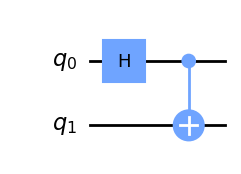

In [9]:
qiskit_bell_circ = QuantumCircuit(2)
qiskit_bell_circ.h(0)
qiskit_bell_circ.cx(0, 1)

qiskit_bell_circ.draw("mpl")

Formerly took 532 secs to complete

In [10]:
backend = AWSBraketProvider().get_backend('SV1')
estimator = BackendEstimator(backend)
qiskit_observables = SparsePauliOp.from_list(([('XX', 0.25), ("IZ", 0.25), ("ZZ", 0.25), ("XY", 0.25)]))

qiskit_start_time = time.time()
job = estimator.run(
    circuits=[qiskit_bell_circ] * batchsize,
    observables=[qiskit_observables] * batchsize,
    shots=n_shots
)
job.result().values # This is the time-consuming line

qiskit_run_batch_time = time.time() - qiskit_start_time
print('--- {} seconds ---'.format(round(qiskit_run_batch_time, 2)))
print('Execution time per circuit:', round(qiskit_run_batch_time / (batchsize * 3), 2), 'seconds')

--- 738.49 seconds ---
Execution time per circuit: 4.92 seconds


In [11]:
qiskit_expvals = job.result().values

#### Use ``Estimator`` from Qiskit

In [12]:
start_time = time.time()
job = Estimator().run(
    circuits=[qiskit_bell_circ] * batchsize,
    observables=[qiskit_observables] * batchsize,
    shots=n_shots
)
qiskit_expvals_2 = job.result().values
run_batch_time = time.time() - start_time
print('--- {} seconds ---'.format(round(run_batch_time, 2)))
# Three non-commuting parts of the Hamiltonian lead to three measured circuits per Hamiltonian
print('Execution time per circuit:', round(run_batch_time / (batchsize * 3), 2), 'seconds')

--- 0.05 seconds ---
Execution time per circuit: 0.0 seconds


In [13]:
qiskit_expvals_2 - qiskit_expvals

array([ 7.67110466e-03,  2.58415666e-03,  3.61985499e-03,  4.42866924e-03,
       -2.46893913e-03, -1.11221964e-02,  2.26712347e-03,  2.46853783e-04,
        6.43258209e-03, -2.26211228e-03,  5.33842066e-04, -4.65794072e-03,
       -1.95281299e-03, -6.23364340e-03, -9.12855533e-04, -4.35090511e-03,
       -5.15256435e-03, -8.87581587e-03,  6.25261189e-03,  3.82411133e-03,
       -4.10180134e-04,  9.24700485e-04,  5.26876309e-03, -6.76792196e-03,
        1.20318508e-03,  1.72565225e-04,  3.04426733e-03,  4.53873546e-03,
        1.07839960e-03, -2.49713228e-03, -1.06106280e-03, -8.87506575e-03,
       -6.09602532e-03, -1.84990558e-03,  5.44129848e-03,  5.70111903e-03,
       -5.30992304e-03, -1.00768114e-03, -2.85305528e-04, -8.10302736e-03,
        7.38356664e-03,  6.27542532e-04,  2.24005552e-03,  3.27422482e-03,
        8.58477974e-04, -7.56000552e-04, -8.84480275e-03,  2.34205997e-04,
       -5.30753701e-03, -3.33486964e-05])

In [14]:
max(qiskit_expvals_2 - qiskit_expvals)

0.007671104663567796

#### Running batch of qiskit circuits with SV1 backend provider

In [15]:
backend = AWSBraketProvider().get_backend('SV1')

In [16]:
qiskit_start_time = time.time()
job = backend.run(
    [qiskit_bell_circ] * batchsize,
    shots=n_shots
)
result = job.result() # This is the time-consuming line

qiskit_run_batch_time = time.time() - qiskit_start_time
print('--- {} seconds ---'.format(round(qiskit_run_batch_time, 2)))
print('Execution time per batch:', round(qiskit_run_batch_time / batchsize, 2), 'seconds')

--- 222.57 seconds ---
Execution time per batch: 4.45 seconds
